# Example: ETDRS Analysis stratified by vessel size

This jupyter notebook shows how to quantitatively analyze a dataset of OCTA images using our graph extraction pipeline. In the end, we will be able to compare vessel density of a dataset stratified by vessel size and by sector in the ETDRS grid.

## Prerequisites

- [Docker](https://www.docker.com/) installation
- A dataset of OCTA images. The DVC must be present in the images or in a separate image file. We provide two synthetic sample segmentations under `/data/src`

## 1. Installation

In this tutorial we will use the provided docker image to avoid the elaborate manual installation of Voreen. So let us start by building the docker image:

In [ ]:
# Use echo to provide inputs to the setup script
INPUT_DIR=... # TODO
TMP_DIR=... # TODO
OUTPUT_DIR=... # TODO
!echo -e "1\n${TMP_DIR}\n${INPUT_DIR}\n${OUTPUT_DIR}\n" | ./setup.sh


╔════════════════════════════════════════════════════════════════╗
║                    OCTA Graph Extraction                       ║
║                     Complete Setup                             ║
╚════════════════════════════════════════════════════════════════╝

Please select your setup mode:
1) 🐍 Host Python + Docker Voreen (recommended for development)
2) 🐳 Full Docker Setup (recommended for production/simple usage)

Selected: Host Python + Docker Voreen setup

▶ 1. Checking Prerequisites
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  ✅ Docker found: 28.1.1
  ✅ Docker daemon is running
  ✅ UV found: uv 0.6.9
  ✅ Python found: Python 3.13.2

▶ 2. Detecting System Configuration
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  ℹ️  User ID: 20871
  ℹ️  Group ID: 20909
  ℹ️  Docker Group ID: 988
  ✅ User is in docker group

▶ 3. Configuring Environment
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  ℹ️  Updating .env fi

Next we install the necessary dependencies for this tutorial

In [1]:
import os
from glob import glob

import matplotlib as mpl
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from matplotlib import pyplot as plt
from matplotlib.colors import colorConverter
from natsort import natsorted
from PIL import Image

load_dotenv()

True

In [2]:
SRC_DIR = os.getenv("HOST_SRC_DIR")
OUT_DIR = os.getenv("HOST_OUTPUT_DIR")

# 2. Segmentation

Check out [our tool for OCTA segmentation](https://github.com/aiforvision/OCTA-autosegmentation) and create the segmentation maps for your dataset. If the provided pre-trained model does not offer good performance for your dataset, you can train your own. Check out our example jupyter notebooks! 

**After** you segmented your images, you can visualize them running the cell below.

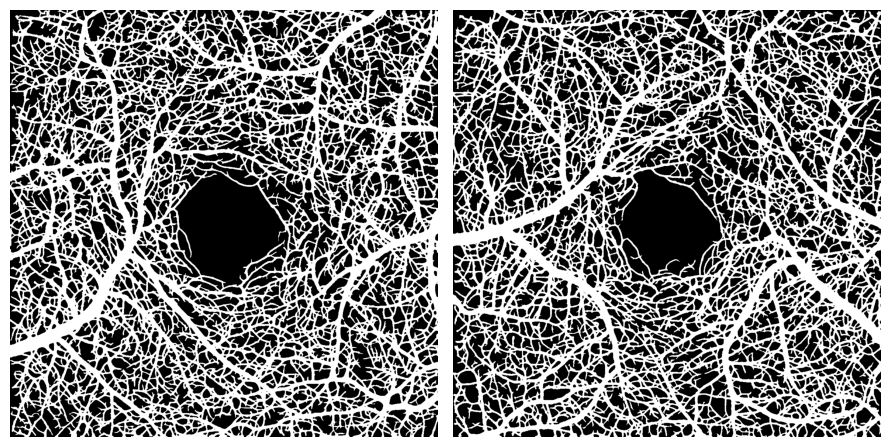

In [3]:
path_to_segmentations: str = f"{SRC_DIR}/*.png"

image_paths = natsorted(glob(path_to_segmentations, recursive=True))
assert len(image_paths)>0, f"No files found for path {path_to_segmentations}"
_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
ax1.imshow(Image.open(image_paths[0]), cmap="gray")
ax1.axis('off')
ax2.imshow(Image.open(image_paths[1]), cmap="gray")
ax2.axis('off')
plt.tight_layout()

# 3. FAZ segmentation

We will now use the segmentation maps of the DVC to predict a segmentation of the FAZ.

> [!NOTE] Our script requires a reasonable image quality / segmentation quality for an accurate faz segmentation

In [ ]:
!python faz_segmentation.py --source_files "${HOST_SRC_DIR}/*.png" --output_dir ${HOST_OUTPUT_DIR} --threads 1

Segmenting FAZ...: 100%|██████████████████████████| 2/2 [00:05<00:00,  2.95s/it]


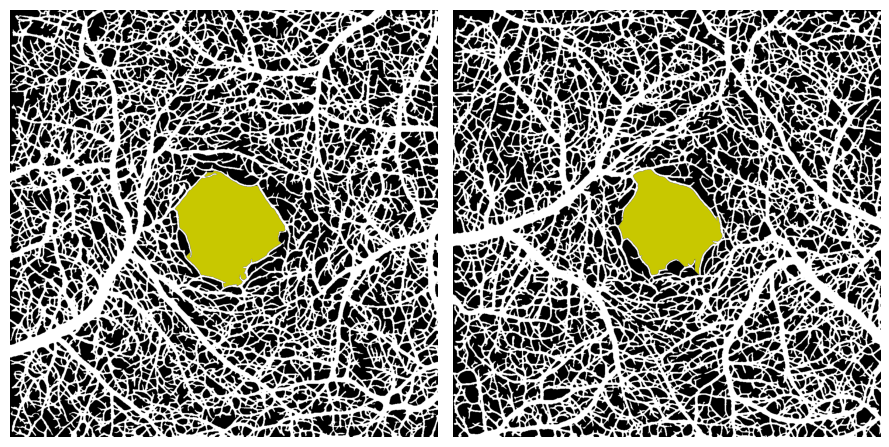

In [9]:
path_to_faz_segmentations: str = f"{OUT_DIR}/*.png"

faz_paths = natsorted(glob(path_to_faz_segmentations, recursive=True))
assert len(faz_paths)>0, f"No files found for path {path_to_faz_segmentations}"

# generate the colors for your colormap
color1 = colorConverter.to_rgba('white')
color2 = colorConverter.to_rgba('black')

# make the colormaps
cmap1 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap',[color2,color1],256)
cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap2',[color1,"yellow"],256)

cmap2._init() # create the _lut array, with rgba values

# create your alpha array and fill the colormap with them.
# here it is progressive, but you can create whathever you want
alphas = np.linspace(0, 0.8, cmap2.N+3)
cmap2._lut[:,-1] = alphas

_, (ax1,ax2) = plt.subplots(nrows=1,ncols=2, figsize=(9,5))
ax1.imshow(Image.open(image_paths[0]), cmap=cmap1)
ax1.axis('off')
ax1.imshow(Image.open(faz_paths[0]), cmap=cmap2, origin="lower")
ax1.invert_yaxis()
ax2.imshow(Image.open(image_paths[1]), cmap=cmap1)
ax2.axis('off')
ax2.imshow(Image.open(faz_paths[1]), cmap=cmap2, origin="lower")
ax2.invert_yaxis()

plt.tight_layout()

## 3. Vessel graph extraction

We will now perform the vessel graph extraction. In this example, we will use the analysis using the ETDRS grid. The center of the ETDRS grid is set to the center of mass of the FAZ that we segmented in the last step. The result will be a folder for each sample containing the analysis per sector.

In [ ]:
!python graph_feature_extractor.py --image_files "${HOST_SRC_DIR}/*.png" --output_dir ${HOST_OUTPUT_DIR} --etdrs --faz_dir ${HOST_OUTPUT_DIR}

No running container for image voreen found. Starting a new container...
Extracting graph features...: 100%|███████████████| 2/2 [02:58<00:00, 89.14s/it]
Container 'happy_aryabhata' stopped and removed.
rm: cannot remove '/var/tmp/systemd-private-3df98f87c38c4fa3a1e7fe86ae449aed-ModemManager.service-QaKlRs': Operation not permitted
rm: cannot remove '/var/tmp/systemd-private-3df98f87c38c4fa3a1e7fe86ae449aed-fwupd.service-CahL5h': Operation not permitted
rm: cannot remove '/var/tmp/systemd-private-3df98f87c38c4fa3a1e7fe86ae449aed-polkit.service-RnA6Wl': Operation not permitted
rm: cannot remove '/var/tmp/systemd-private-3df98f87c38c4fa3a1e7fe86ae449aed-systemd-logind.service-3KBZpK': Operation not permitted
rm: cannot remove '/var/tmp/systemd-private-3df98f87c38c4fa3a1e7fe86ae449aed-systemd-resolved.service-gnwXcj': Operation not permitted
rm: cannot remove '/var/tmp/systemd-private-3df98f87c38c4fa3a1e7fe86ae449aed-systemd-timesyncd.service-a8xS6l': Operation not permitted
rm: cannot re

Let us take a look at the extracted graph:

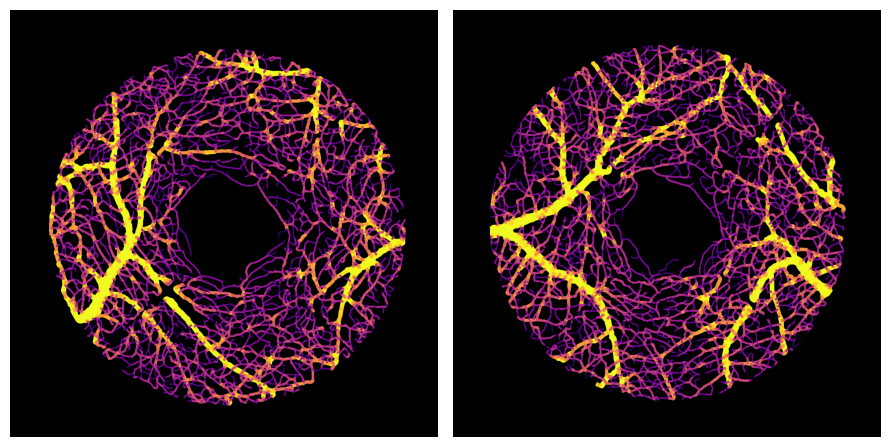

In [8]:
path_to_graph_folder: str = OUT_DIR
graph_images_paths = natsorted(glob(os.path.join(path_to_graph_folder, "**/*graph.png"), recursive=True))
assert len(graph_images_paths)>0, f"No files found for path {path_to_graph_folder}"

_, (ax1,ax2) = plt.subplots(nrows=1,ncols=2, figsize=(9,5))
img = 0
for p in graph_images_paths[:5]:
    img += np.array(Image.open(p))
ax1.imshow(img)
ax1.axis('off')

img = 0
for p in graph_images_paths[5:10]:
    img += np.array(Image.open(p))
ax2.imshow(img)
ax2.axis('off')
plt.tight_layout()

As we can see the vessel sizes have been correctly identified and are color coded by their size. Because we mask the segmentations, there a small gaps at the borders of the ETDRS grid.

Let us have a look at the graph features next:

In [10]:
c0_csv_path = natsorted(glob(os.path.join(path_to_graph_folder, "**/*.csv"), recursive=True))[0]
df = pd.read_csv(c0_csv_path, sep=";",index_col=0)
df.head()

,node1id,node2id,length,distance,curveness,volume,avgCrossSection,minRadiusAvg,minRadiusStd,avgRadiusAvg,avgRadiusStd,maxRadiusAvg,maxRadiusStd,roundnessAvg,roundnessStd,node1_degree,node2_degree,num_voxels,hasNodeAtSampleBorder
id,,,,,,,,,,,,,,,,,,,
0,1,41,26.3119,22.8035,1.15385,1762,66.9659,2.68400,2.575530,4.08235,2.472990,5.28989,2.817520,0.422194,0.208892,1,3,23,0
1,0,42,10.7934,10.2956,1.04835,129,11.9517,1.58791,0.405639,2.15541,0.438455,2.74043,0.683717,0.607881,0.155785,1,3,9,0
2,42,43,3.0000,3.0000,1.00000,70,23.3333,2.73694,0.000000,3.21647,0.066140,3.68259,0.000000,0.743210,0.000000,3,3,2,0
3,41,44,16.3475,16.1245,1.01383,1258,76.9538,5.14069,1.062230,5.75353,1.159060,6.47542,1.269890,0.795867,0.063804,3,3,13,0
4,42,44,16.6943,16.1245,1.03533,395,23.6608,2.48113,0.746131,2.97902,0.772815,3.43214,0.906436,0.725082,0.102431,3,3,14,0


> [!NOTE]
> In experiments with synthetic data (1216x1216 px^2), we found that Voreen overestimates the `avgRadiusAvg` of vessels by a fixed additive factor of 1 pixel!
> We therefore correct for this by subtracting the `radius_correction_factor` when generating the graph image from the graph json file. This affects the density estimation in the next step.

## 4. Analysis

We will now collect all metrics of each sample to generate a analysis summary.

> [!IMPORTANT]
> The script expects your graph data to be organized in the following schema:
> - Folder structure: `.../<Group>/<ImageName>/<ImageName>_edges.csv` for etdrs or `.../Group/<ImageName>_edges.csv`
> - `<ImageName>` consist of `<ImageUUID>` and `<EyeCode>` which is either `_OS` or `_OD`
> - Path contains the `<PlexusCode>` either `SVC`/`SCP` or `DVC`/`DCP`.
> - For ETDRS analysis, the `<ImageName>` must contain the `<SectorCode>` (`C0`, `S1`, `N1`, `I1`, `T1`)

In [ ]:
!python generate_analysis_summary.py --source_dir $HOST_OUTPUT_DIR --segmentation_dir $HOST_SRC_DIR --output_dir $HOST_OUTPUT_DIR --faz_files "${HOST_OUTPUT_DIR}/faz*.png" --etdrs --radius_thresholds 5

100%|███████████████████████████████████████████| 10/10 [00:06<00:00,  1.44it/s]


Let us now have a look at the summary file:

In [16]:
summary_file_path: str = f"{OUT_DIR}/density_measurements_etdrs.csv"
df = pd.read_csv(summary_file_path)
df.head()

,Image_ID,Group,Eye,Layer,FAZ area [mm2],C0 Density (radius < 5.0um) [%],C0 Density (5.0um < radius) [%],S1 Density (radius < 5.0um) [%],S1 Density (5.0um < radius) [%],N1 Density (radius < 5.0um) [%],N1 Density (5.0um < radius) [%],I1 Density (radius < 5.0um) [%],I1 Density (5.0um < radius) [%],T1 Density (radius < 5.0um) [%],T1 Density (5.0um < radius) [%]
0,G_20230216_232653,test_out,OD,DVC,0.392574,7.450172,9.454915,7.330271,36.540948,7.679789,35.637545,9.144504,34.677376,5.871434,47.073742
1,G_20230216_232741,test_out,OS,DVC,0.328890,7.157636,13.013778,7.561122,37.559410,7.044720,41.760620,7.860343,36.229675,6.948829,41.208515


> [!NOTE]
> Absolute values of the radii are difficult to verify. We recommend to mainly use relative comparisons, e.g. Patients from cohortA have a lower vessel density for small vessels than patients from cohortB

## What's next?

Congratulations, you made it trough the example! 🎉

You can now start to optimize your pipeline. Possible things you might want to try next:
- Improve you vessel segmentation. See our [vessel segmentation tool](https://github.com/TUM-AIMED/OCTA-seg#1-to-segment-a-set-of-images-replace-the-placeholders-with-your-directory-paths-and-run)
- Play around with the different features provided by voreen e.g., vessel curveness, etc.